In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import scipy as sp
#%matplotlib inline
%matplotlib notebook
sns.set()
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Load the Data

In [3]:
#raw data 
base = "../data/home/share/data/public_sets/WISDM_at_v2.0/"
raw = pd.read_csv(base+'WISDM_at_v2.0_raw.txt', sep=",",
                  names=["user", "activity", "timestamp", "x", "y", "z"],
                  low_memory=False).dropna()
raw.drop([409831, 779331, 779332], inplace=True) #timestamps are indecipherable
raw["timestamp"] = pd.to_datetime(raw["timestamp"], unit="ms")
raw.reset_index(drop=True, inplace=True)
raw["z"] = raw["z"].apply(lambda x: float(x[:-1]))

In [5]:
#separate the time and date
raw["date"] = raw["timestamp"].apply(lambda x: x.date())
raw["time"] = raw["timestamp"].apply(lambda x: x.time())

In [7]:
raw.head()

,user,activity,timestamp,x,y,z,date,time
0,1679,Walking,2013-06-06 12:07:49.556,0.294132,-0.635605,-0.226936,2013-06-06,12:07:49.556000
1,1679,Walking,2013-06-06 12:07:49.606,-0.499688,-0.604451,-0.226020,2013-06-06,12:07:49.606000
2,1679,Walking,2013-06-06 12:07:49.656,-2.178345,0.713491,0.372017,2013-06-06,12:07:49.656000
3,1679,Walking,2013-06-06 12:07:49.706,-2.797763,1.354899,-0.277638,2013-06-06,12:07:49.706000
4,1679,Walking,2013-06-06 12:07:49.756,-2.167961,-1.327716,-0.554971,2013-06-06,12:07:49.756000


In [8]:
#group by session as determined by user, activity and date
raw_bysession = pd.DataFrame(raw.groupby(["user", "activity", "date"])\
                                .apply(lambda x: x[["x", "y", "z"]].values),
                             columns=["tri-accel"]).reset_index()
fs = 20 #Hz sampling rate of the device
raw_bysession["duration"] = raw_bysession["tri-accel"].apply(lambda x: len(x)*fs/60) #in min

In [142]:
raw_bysession.head()

,user,activity,date,tri-accel,duration,group
0,194,Jogging,2013-06-04,"[[5.0994577, 8.825985, 0.0392266], [8.551398, ...",1266.333333,Test
1,194,LyingDown,2013-06-04,"[[10.120462, 0.69627213, 1.2846711], [10.08123...",133.333333,Test
2,194,Sitting,2013-06-04,"[[2.2359161, 4.903325, 7.3157606], [9.071151, ...",66.000000,Test
3,194,Sitting,2013-06-20,"[[-0.0031957934, 0.07243798, 0.058589544], [0....",798.000000,Test
4,194,Stairs,2013-06-04,"[[2.0005565, 3.3734875, 0.7649187], [2.3143694...",2066.666667,Test


### Train and Test Split

We split the data to train and test set by users. This means a particular user can only be assigned in either train or test set but neither to both. (90-10)

In [44]:
users = raw_bysession["user"].unique()
train = np.random.choice(users, size=int(0.9*len(users)))
test = np.array([i for i in users if i not in train])

raw_bysession["group"] = raw_bysession["user"].apply(lambda x: "Train" if x in train else "Test")

In [45]:
#some stats in train
raw_bysession[raw_bysession["group"]=="Train"].groupby("activity").apply(lambda x: len(x))

activity
Jogging       35
LyingDown     27
Sitting       74
Stairs        18
Standing      56
Walking      127
dtype: int64

In [46]:
#some stats in test
raw_bysession[raw_bysession["group"]=="Test"].groupby("activity").apply(lambda x: len(x))

activity
Jogging      21
LyingDown    17
Sitting      39
Stairs        4
Standing     31
Walking      84
dtype: int64

### Split the Accelerometer data to 5 sec

In [97]:
def window_segmenter(x, fs, window_dur):
    """
    PARAMETERS
    ----------
    x:           array to segment of shape (num_axes, num_datapoints)
    fs:          sampling frequency
    window_dur:  duration of the window segment in seconds 
    
    RETURNS
    -------
    new_x:       array of shape (num_datapoints//fs*window_dur,num_axes,fs*window_dur) 
    """
    
    window_dpt = fs*window_dur
    x = x[:, :x.shape[1]-(x.shape[1]%window_dpt)]
    new_x = x.reshape((x.shape[0], x.shape[1]//window_dpt, window_dpt)).transpose((1,0,2))
    return new_x

In [112]:
fs = 20 #Hz (see WISDM_at_v2.0_raw_about.txt)
window_duration = 5 #in seconds

In [113]:
raw_bysession.head()

,user,activity,date,tri-accel,duration,group
0,194,Jogging,2013-06-04,"[[5.0994577, 8.825985, 0.0392266], [8.551398, ...",1266.333333,Test
1,194,LyingDown,2013-06-04,"[[10.120462, 0.69627213, 1.2846711], [10.08123...",133.333333,Test
2,194,Sitting,2013-06-04,"[[2.2359161, 4.903325, 7.3157606], [9.071151, ...",66.000000,Test
3,194,Sitting,2013-06-20,"[[-0.0031957934, 0.07243798, 0.058589544], [0....",798.000000,Test
4,194,Stairs,2013-06-04,"[[2.0005565, 3.3734875, 0.7649187], [2.3143694...",2066.666667,Test


In [136]:
new_raw_bysession = pd.DataFrame()
for i in raw_bysession.index:
    df = pd.DataFrame({"accel":list(window_segmenter(raw_bysession.iloc[i]["tri-accel"].T, fs, window_duration)),
                      "user": raw_bysession.iloc[i]["user"],
                      "activity": raw_bysession.iloc[i]["activity"],
                      "date": raw_bysession.iloc[i]["date"],
                      "group": raw_bysession.iloc[i]["group"]})
    new_raw_bysession = pd.concat((new_raw_bysession, df)).reset_index(drop=True)

In [138]:
new_raw_bysession.head()

,accel,activity,date,group,user
0,"[[5.0994577, 8.551398, 0.78453195, -3.9030466,...",Jogging,2013-06-04,Test,194
1,"[[-4.256086, -12.081793, 4.6679654, 22.202255,...",Jogging,2013-06-04,Test,194
2,"[[-5.3838506, 5.1386843, -0.0, 5.64863, -4.059...",Jogging,2013-06-04,Test,194
3,"[[1.4513842, 3.4519408, -4.726805, -7.482474, ...",Jogging,2013-06-04,Test,194
4,"[[-1.2944778, 9.492837, 9.139797, 5.060231, 2....",Jogging,2013-06-04,Test,194


In [139]:
#take a look at the new stats
#train
new_raw_bysession[new_raw_bysession["group"]=="Train"].groupby("activity").apply(lambda x: len(x))

activity
Jogging      2389
LyingDown    2329
Sitting      4835
Stairs        449
Standing     1747
Walking      7620
dtype: int64

In [140]:
#test
new_raw_bysession[new_raw_bysession["group"]=="Test"].groupby("activity").apply(lambda x: len(x))

activity
Jogging      1973
LyingDown     403
Sitting      1739
Stairs        120
Standing     1094
Walking      4838
dtype: int64

In [143]:
new_raw_bysession.groupby("group").apply(lambda x: len(x))

group
Test     10167
Train    19369
dtype: int64

### Take the CWT of the magnitude of the tri-axial accelerometer.

In [173]:
from sensorlib.features import cwt_fft

def cwt(signal, fs):
    res, freq, time = cwt_fft(signal, dt=1/fs, low_freq=0.1, high_freq=4)
    cwt_magnitude = np.abs(res["W"][freq][:, time])
    freqs = res["freqs"][freq]
    t = np.arange(0, len(signal))/fs
    return cwt_magnitude, freqs, time

In [194]:
new_raw_bysession["cwt-accel"] = new_raw_bysession["accel"].apply(lambda x: cwt(np.sqrt(np.sum(x**2, axis=0)), fs)[0])

In [195]:
new_raw_bysession.head()

,accel,activity,date,group,user,cwt-accel
0,"[[5.0994577, 8.551398, 0.78453195, -3.9030466,...",Jogging,2013-06-04,Test,194,"[[10.2963464499, 11.7604175562, 13.0574779151,..."
1,"[[-4.256086, -12.081793, 4.6679654, 22.202255,...",Jogging,2013-06-04,Test,194,"[[14.084580537, 14.5372484008, 14.7390335906, ..."
2,"[[-5.3838506, 5.1386843, -0.0, 5.64863, -4.059...",Jogging,2013-06-04,Test,194,"[[1.65709609806, 2.40704071205, 3.43537195961,..."
3,"[[1.4513842, 3.4519408, -4.726805, -7.482474, ...",Jogging,2013-06-04,Test,194,"[[2.00382015744, 1.97897841814, 2.34455287998,..."
4,"[[-1.2944778, 9.492837, 9.139797, 5.060231, 2....",Jogging,2013-06-04,Test,194,"[[14.8524722421, 15.8111569941, 16.2461343851,..."


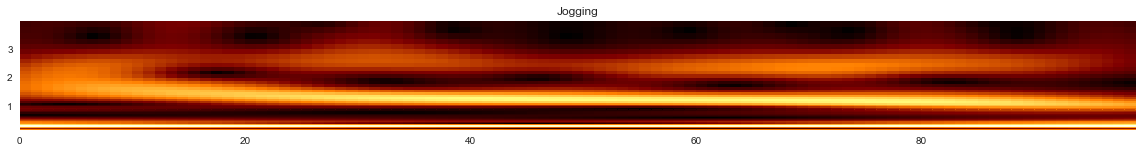

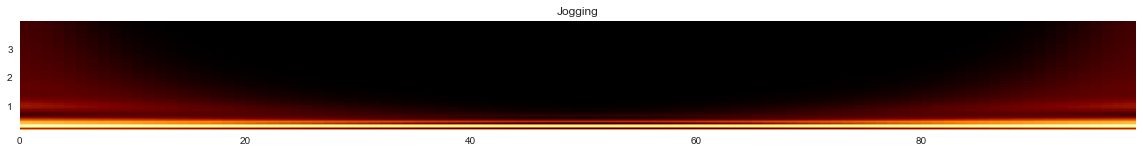

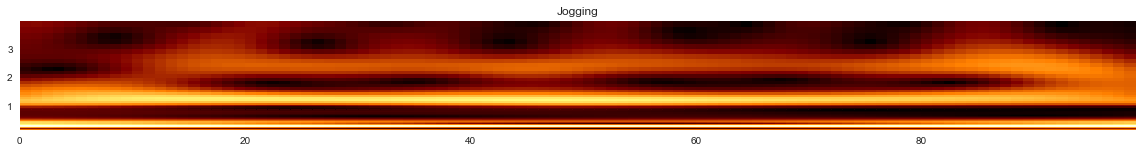

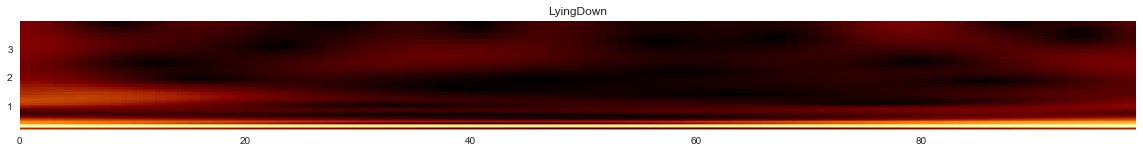

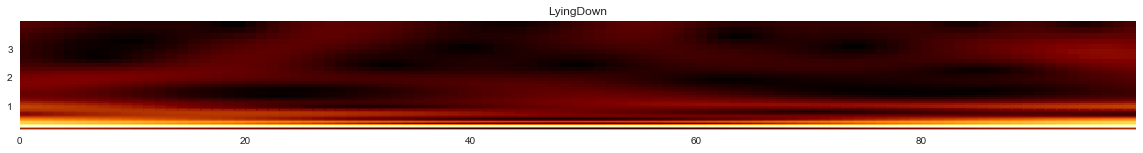

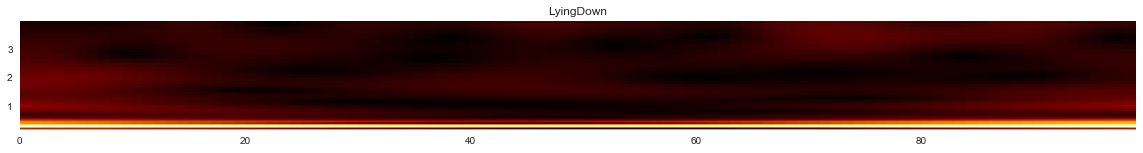

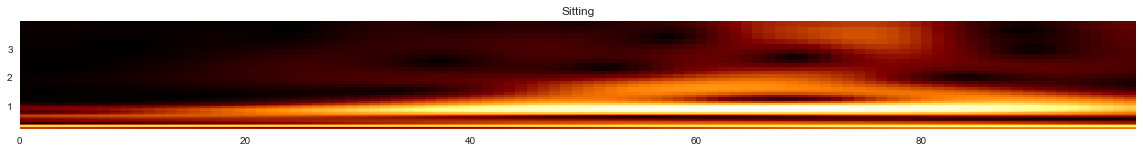

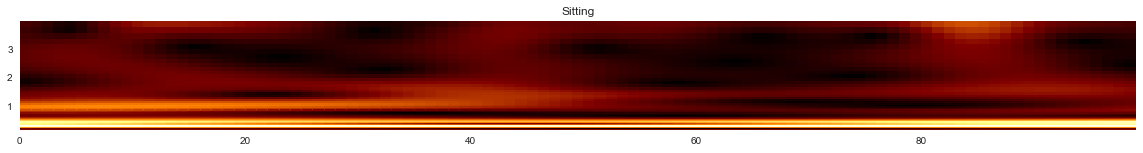

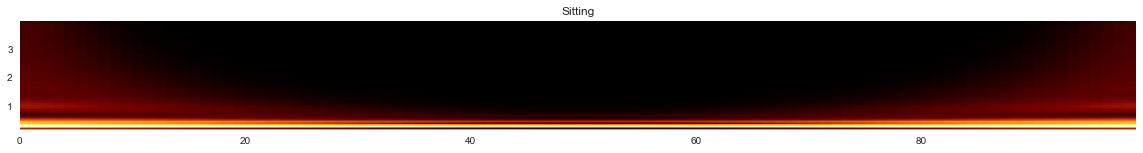

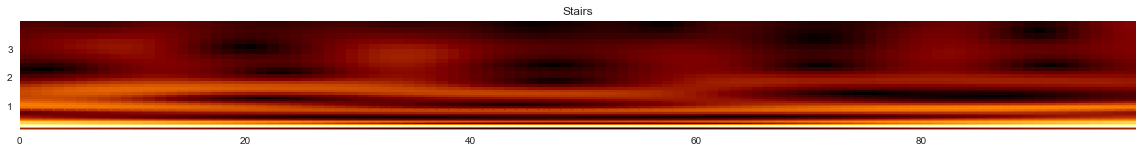

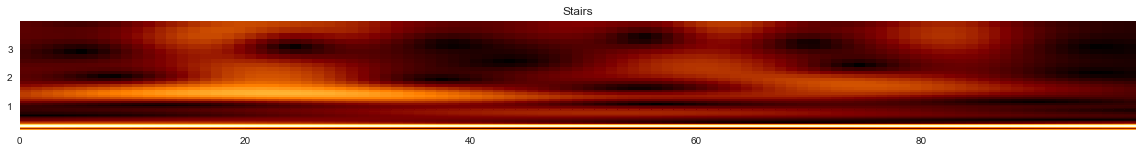

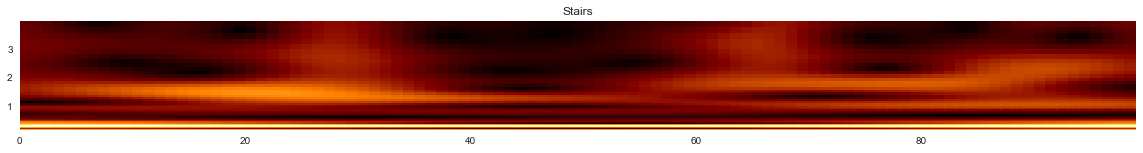

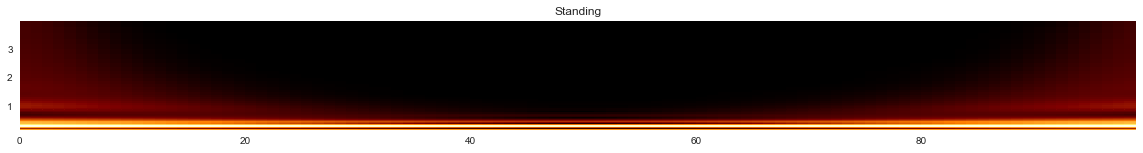

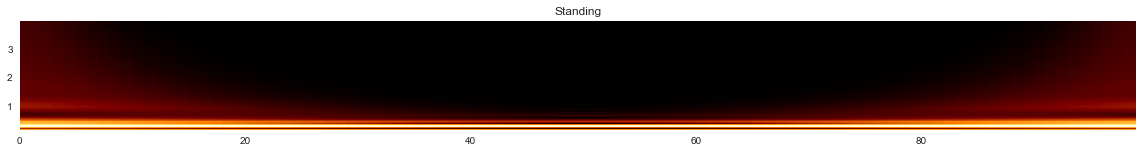

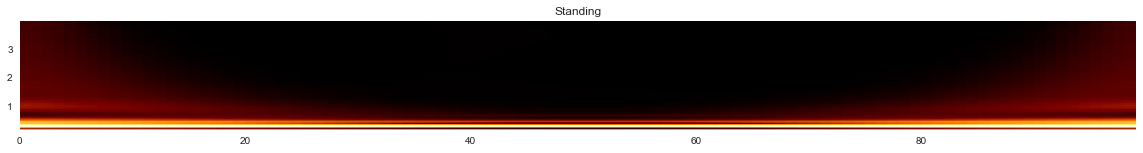

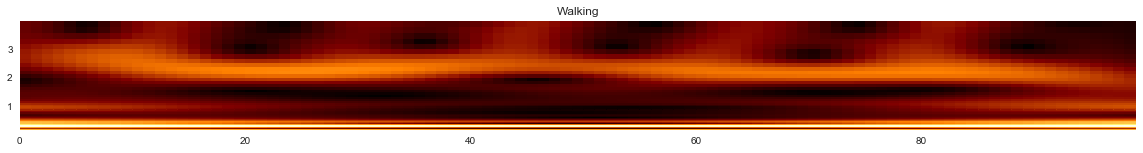

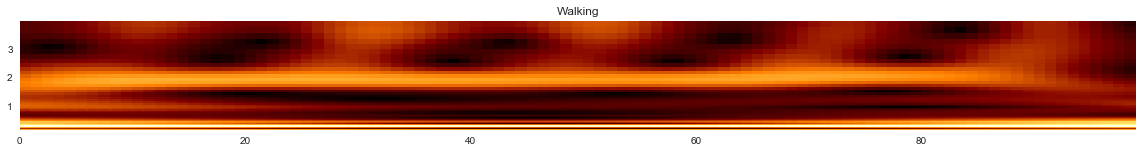

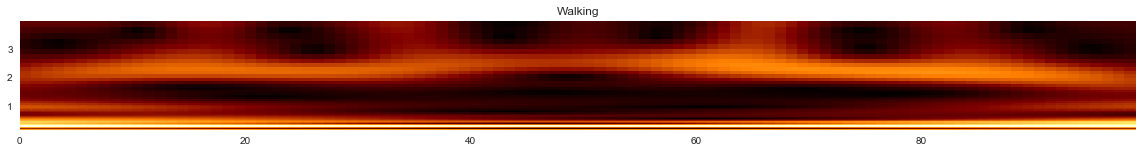

In [221]:
#plot some samples
nsamp_per_act = 3
activities = new_raw_bysession["activity"].unique()

#frequencies in cwt
freq = cwt(np.sqrt(np.sum(new_raw_bysession["accel"][0]**2, axis=0)), fs)[1]

for act in activities:
    act_df = new_raw_bysession[new_raw_bysession["activity"]==act]
    for i in np.random.choice(np.arange(len(act_df)), replace=False, size=nsamp_per_act):
        plt.figure(figsize=(20,2))
        plt.pcolormesh(np.arange(act_df.iloc[i]["cwt-accel"].shape[1]),
                       freq,
                       act_df.iloc[i]["cwt-accel"], cmap="afmhot")
        plt.title(act)